Hint Generation Tests
===

Goal: explain to the student why their answer is wrong.

Axis 1:
 - With revealing the right answer
 - Without revealing the right answer

Axis 2:
 - Using no lesson content? (Probably not, doesn't matter how good this is.)
 - Using lesson context only
 - Using larger Rori context
 - Using Rori + external math corpus context

Axis 3:
 - Single prompt, no CoT
 - Single CoT prompt + refinement prompt
 - Multi-stage refinment or retrieval

In [1]:
import json
import locale
import os
import time
from collections import defaultdict
from pathlib import Path
from pprint import pprint

import dotenv
import matplotlib.pyplot as plt
import numpy as np
import openai
import pandas as pd
import scipy
import tiktoken
from tqdm import tqdm

In [2]:
dotenv.load_dotenv("../.env")

True

In [3]:
os.environ["OPENAI_API_KEY"][:3]

'sk-'

In [4]:
openai.api_key = os.environ["OPENAI_API_KEY"]

In [5]:
data_dir = Path("../data")
assert data_dir.exists()
lesson_df = pd.read_pickle(data_dir / "derived" / "rori_lessons.pkl")
lesson_df.shape

(2570, 20)

In [6]:
lesson_df = lesson_df.reset_index().rename(columns={"index": "unique_index"})

In [7]:
lesson_df.columns

Index(['unique_index', 'lesson_code', 'grade', 'domain', 'construct',
       'subconstruct', 'skill', 'lesson_index', 'topic', 'short_description',
       'lesson', 'question', 'answer', 'hint', 'has_image', 'section',
       'question_index', 'is_explanation', 'needs_context', 'context_string',
       'n_question_tokens'],
      dtype='object')

In [8]:
lesson_df.sample(n=3)

,unique_index,lesson_code,grade,domain,construct,subconstruct,skill,lesson_index,topic,short_description,...,question,answer,hint,has_image,section,question_index,is_explanation,needs_context,context_string,n_question_tokens
1679,1679,G4.N1.1.2.4,4,N,N1,N1.1,N1.1.2,4,Compare and order (4 of 7),"Today, we will order numbers from largest to s...",...,"13, 942, 1,620 and 5.\n \nA. 1,620, 942, 13, 5...",A,Numbers with more digits are larger. \nSo the ...,False,1,1,False,False,,18.0
109,109,G9.A2.1.3.1,9,A,A2,A2.1,A2.1.3,1,Expressions (1 of 2),"Today, we are going to learn how to multiply t...",...,(x - 9) (x + 4)\n\nA. x² + 5x + 36\nB. x² - 5x...,B,Use the FOIL method to get \nx² + 4x - 9x - 36...,False,2,7,False,False,,26.0
1588,1588,G3.N1.3.3.24,3,N,N1,N1.3,N1.3.3,24,Divide ( 2 of 4),We have already learned dividing numbers. \nTo...,...,40 ÷ ?= 4\n\nA. 10\nB. 8,A,4 times which number make 40.,False,1,3,False,False,,6.0


In [9]:
lesson_df[["question_index", "is_explanation", "section", "lesson", "question", "answer", "hint"]].sample(n=3)

,question_index,is_explanation,section,lesson,question,answer,hint
586,0,True,1,The circle is a curved shape with a centre. Th...,None,None,None
2032,6,True,2,You did great!\n\nThe place value of a digit i...,None,None,None
226,0,True,1,Circles are measured using radius and diameter...,None,None,None


#### Incorrect answers and misconceptions

Based on student answer data

In [10]:
student_answers_filepath = data_dir / "raw" / "rori" / "math_student_answers_5.15_6.16.csv"
answer_df = pd.read_csv(student_answers_filepath).rename(columns={"Unnamed: 0": "answer_id"})
answer_df.shape

(74653, 19)

In [11]:
answer_df.columns

Index(['answer_id', 'original_message_id', 'text', 'message_inserted_at',
       'nlu_response_data', 'nlu_response_type', 'nlu_response_confidence',
       'contact_uuid', 'question', 'question_level', 'question_skill',
       'question_topic', 'question_number', 'expected_answer',
       'question_micro_lesson', 'line_name', 'line_number', 'answer_type',
       'supabase_id'],
      dtype='object')

In [15]:
question_map = defaultdict(list)
answer_map = defaultdict(list)
for row in lesson_df[(lesson_df.question.notna()) & (~lesson_df.has_image)].itertuples():
    q = row.question
    a = row.answer
    q_normalized = q.replace("\n", " ").strip()
    question_map[(q_normalized, row.lesson_code)].append(int(row.unique_index))
    answer_map[q_normalized].append(a)
len(question_map)

1780

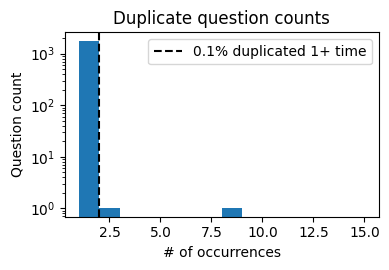

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2.8))

counts = np.array([len(l) for l in question_map.values()])
ax.hist(counts, bins=np.arange(1, 16), log=True)

ax.axvline(2, color="black", linestyle="--", label=f"{(counts > 1).sum() / len(counts):.1%} duplicated 1+ time")

ax.set_title("Duplicate question counts")
ax.set_xlabel("# of occurrences")
ax.set_ylabel("Question count")
ax.legend()

fig.tight_layout()
plt.show()

In [17]:
# all multi-answer questions have associated images; makes sense
for q, answers in answer_map.items():
    if len({str(a).strip() for a in answers}) > 1:
        print(f"{q} {answers}")

In [24]:
def normalize_text(t):
    if type(t) != str:
        return t
    return t.replace("\n", " ").strip()


def get_index(q, lesson_code):
    q_normalized = normalize_text(q)
    index = (q_normalized, lesson_code)
    if index not in question_map:
        return None
    if len(question_map[index]) > 1:
        return None
        # assert False, index
    return question_map[index][0]


answer_df["question_index"] = [get_index(row.question, row.question_micro_lesson) for row in answer_df.itertuples()]
answer_df.question_index.notna().sum() / len(answer_df)

0.722556360762461

In [25]:
m = answer_df.merge(
    lesson_df[["unique_index", "question", "answer"]],
    left_on="question_index",
    right_on="unique_index",
    how="inner",
    validate="many_to_one",
    suffixes=("", "_merged"),
)
# should be the same
(m.question.map(normalize_text) == m.question_merged.map(normalize_text)).sum(), len(m)

(53941, 53941)

In [26]:
m["is_answer_mismatch"] = m.expected_answer.map(normalize_text) == m.answer.map(normalize_text)
m.is_answer_mismatch.sum(), len(m), m.groupby("question_index").is_answer_mismatch.any().sum()

(13961, 53941, 628)

In [27]:
mismatched_questions = m.groupby("question_index").is_answer_mismatch.any()
mismatched_questions = set(mismatched_questions[mismatched_questions].index)
len(mismatched_questions)

628

In [28]:
answer_df.nlu_response_data.value_counts().head(15)

nlu_response_data
Yes     8101
5       2730
next    2252
menu    1986
B       1946
9       1910
10      1868
30      1830
A       1796
24      1711
C       1657
2       1552
12      1525
26      1484
7       1432
Name: count, dtype: int64

In [21]:
answer_df[answer_df.nlu_response_data.map(len) > 3].nlu_response_data.value_counts().head(15)

nlu_response_data
next          2252
menu          1986
harder         737
skip           485
hint           390
stop           378
Even           302
greeting       286
okay           273
math topic     262
help           234
wait           219
exit           214
math           214
Next           182
Name: count, dtype: int64

In [29]:
sdf = answer_df.merge(
    lesson_df[["unique_index", "question", "answer"]],
    left_on="question_index",
    right_on="unique_index",
    how="inner",
    validate="many_to_one",
    suffixes=("", "_merged"),
)
sdf["expected_answer"] = sdf["answer"]  # due to confirmed bug, override mismatched answers
# sdf = answer_df[(answer_df.question_index.notna())&(~answer_df.question_index.isin(mismatched_questions))]
sdf = sdf[
    ~sdf.nlu_response_data.isin(
        [
            "next",
            "menu",
            "harder",
            "skip",
            "hint",
            "math",
            "math topic",
            "stop",
            "greeting",
            "okay",
            "help",
            "wait",
            "exit",
            "tomorrow",
        ]
    )
]
sdf.shape

(50435, 23)

In [30]:
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")

'en_US.UTF-8'

In [36]:
locale.atof("-5") == locale.atoi("-5")

True

In [40]:
# now, filter to only incorrect answers


def normalize_answer(a):
    if type(a) == str:
        try:
            return locale.atof(a)
        except:
            return a.strip()
    else:
        return a


is_wrong_answer = sdf.nlu_response_data.map(normalize_answer) != sdf.expected_answer.map(normalize_answer)
sdf[is_wrong_answer][["text", "nlu_response_data", "expected_answer"]].sample(20)

,text,nlu_response_data,expected_answer
13103,B,B,C
13762,A,A,C
53329,The correct answer:44,Next,44
45689,B,B,C
39321,28,28,29
42422,Ok,1,1/4
404,T,T,F
39171,Thursday,Thursday,Saturday
25729,E,1,T
21767,1 .8,1,1.8


In [41]:
sdf = sdf[is_wrong_answer]
sdf.shape

(10964, 23)

In [42]:
ds = []
for question_index, group in sdf.groupby("question_index"):
    if len(group) > 5:
        counts = group.nlu_response_data.value_counts()
        ds.append(
            {
                "question_index": int(question_index),
                "n_responses": len(group),
                "n_unique_responses": len(counts),
                "most_common": counts.index[0],
                "most_common_n": counts.iloc[0],
                "second_most_common": counts.index[1] if len(counts) > 1 else None,
                "expected_answer": group.iloc[0].expected_answer,
            }
        )
incorrect_df = pd.DataFrame(ds)
print(incorrect_df.shape)
incorrect_df.sample(n=3)

(367, 7)


,question_index,n_responses,n_unique_responses,most_common,most_common_n,second_most_common,expected_answer
100,530,6,5,1,2,1/2,1/6
299,1985,9,1,F,9,None,T
366,2567,7,5,108,2,84,36


In [43]:
incorrect_df = incorrect_df[incorrect_df.most_common_n > 5].reset_index(drop=True)
print(len(incorrect_df))
incorrect_df.most_common.value_counts().head()

153


most_common
A    11
4    11
T     8
7     8
B     7
Name: count, dtype: int64

In [44]:
incorrect_lesson_df = lesson_df.merge(
    incorrect_df[["question_index", "most_common", "most_common_n", "expected_answer"]].rename(
        columns={
            "most_common": "incorrect_answer",
            "incorrect_answer_occurrence": "most_common_n",
        }
    ),
    left_on="unique_index",
    right_on="question_index",
    how="inner",
)
incorrect_lesson_df.shape

(153, 25)

In [48]:
assert (incorrect_lesson_df.answer != incorrect_lesson_df.expected_answer).sum() == 0
incorrect_lesson_df[incorrect_lesson_df.answer == incorrect_lesson_df.expected_answer][["answer", "expected_answer"]]

,answer,expected_answer
0,C,C
1,D,D
2,15,15
3,B,B
4,1/4,1/4
...,...,...
148,A,A
149,4,4
150,4,4
151,18,18


In [50]:
is_actually_correct_answer = incorrect_lesson_df.answer.map(
    normalize_answer
) == incorrect_lesson_df.incorrect_answer.map(normalize_answer)
is_actually_correct_answer.sum()

0

In [51]:
incorrect_lesson_df[is_actually_correct_answer][
    ["unique_index", "question", "answer", "expected_answer", "incorrect_answer"]
]

,unique_index,question,answer,expected_answer,incorrect_answer


In [52]:
for q in incorrect_lesson_df[is_actually_correct_answer][
    ["unique_index", "question", "answer", "incorrect_answer"]
].question:
    print(q)

In [53]:
answer_df[answer_df.question_index == 87].iloc[0][["expected_answer", "question_micro_lesson", "question_number"]]

expected_answer                    A
question_micro_lesson    G9.A3.1.2.1
question_number                    9
Name: 47991, dtype: object

In [54]:
incorrect_lesson_df[~is_actually_correct_answer][["unique_index", "incorrect_answer", "answer"]]

,unique_index,incorrect_answer,answer
0,16,B,C
1,17,A,D
2,54,5,15
3,105,A,B
4,127,1/2,1/4
...,...,...,...
148,2537,B,A
149,2549,8,4
150,2550,2,4
151,2551,6,18


In [55]:
incorrect_lesson_df[~is_actually_correct_answer][["unique_index", "incorrect_answer", "answer"]].sample(n=20)

,unique_index,incorrect_answer,answer
111,1264,44,181
5,128,1/2,1/4
17,366,5,2^5
136,1990,T,F
62,980,25,24
82,1034,B,C
102,1194,67,7
89,1083,3,5
19,388,10,12
29,417,A,B


In [62]:
incorrect_answer_csv_filepath = data_dir / "derived" / "incorrect_answers.csv"
incorrect_lesson_df[["unique_index", "answer", "incorrect_answer"]].to_csv(incorrect_answer_csv_filepath, index=False)

#### Hint generation

In [64]:
incorrect_answer_csv_filepath = data_dir / "derived" / "incorrect_answers.csv"
incorrect_lesson_df = pd.read_csv(incorrect_answer_csv_filepath)
print(incorrect_lesson_df.shape)
incorrect_lesson_df.sample(n=3)

(153, 3)


,unique_index,answer,incorrect_answer
25,412,B,C
21,400,>,=
33,437,A,B


In [65]:
lesson_codes_with_images = set()
for lesson_code, lesson in lesson_df.groupby("lesson_code"):
    has_image_explanation = ((lesson.is_explanation) & (lesson.has_image)).any()
    has_image_question = ((~lesson.is_explanation) & (lesson.has_image)).any()
    has_image = has_image_explanation or has_image_question
    lesson_codes_with_images.add(lesson_code)
len(lesson_codes_with_images)

225

In [66]:
sdf = lesson_df[(lesson_df.lesson_code.isin(lesson_codes_with_images)) & (lesson_df.grade.isin([6, 7, 8]))]
f"{len(sdf)} / {len(lesson_df)}", f"{sdf.lesson_code.nunique()} / {lesson_df.lesson_code.nunique()}"

('904 / 2570', '80 / 225')

In [68]:
# merge in incorrect lessons
sdf = sdf.merge(incorrect_lesson_df[["unique_index", "incorrect_answer"]], on="unique_index", how="left")
sdf.incorrect_answer.notna().sum()

42

In [22]:
lesson_codes = set(sdf.lesson_code)
n_lessons = 3
subset_lesson_codes = set(np.random.choice(np.array(list(lesson_codes)), size=n_lessons, replace=False))
sdf = sdf[sdf.lesson_code.isin(subset_lesson_codes)]
f"{len(sdf)} / {len(lesson_df)}", f"{sdf.lesson_code.nunique()} / {lesson_df.lesson_code.nunique()}"

('33 / 2570', '3 / 225')

In [62]:
message_lists = []

for lesson_code, lesson in sdf.groupby("lesson_code"):
    lesson_plan = lesson.iloc[0].short_description.strip() + "\n\n\n" + lesson.iloc[0].lesson.strip()
    index = 1
    row = lesson.iloc[index]
    while row.is_explanation:
        lesson_plan += "\n\n\n" + row.lesson.strip()
        index += 1
        row = lesson.iloc[index]
    messages = [
        {
            "role": "system",
            "content": "You are going to act as a maths teacher for a 13 year old student who is in grade 6.\n"
            "Your role is to introduce the student to a new topic using the following lesson plan delimited "
            'by triple quotes: """{lesson_plan}"""\n'
            "You will teach the lesson, presenting it in sections and waiting for the student "
            "to indicate they understand before proceeding. If the student has questions, provide "
            "short, encouraging, and educational clarifications.\nYour responses should be at the "
            "level of difficulty of a 12 year old.".format(lesson_plan=lesson_plan),
        }
    ]
    for lesson_component in lesson_plan.split("\n\n\n"):
        messages.extend(
            [
                {
                    "role": "assistant",
                    "content": lesson_component,
                },
                {
                    "role": "user",
                    "content": "Yes, I understand.",
                },
            ]
        )
    question_text = row.question + "\n"
    messages.extend(
        [
            {
                "role": "assistant",
                "content": question_text,
            },
            {
                "role": "user",
                "content": f"I don't understand why the answer is {row.answer}. Please give me a hint.",
            },
        ]
    )
    message_lists.append(messages)

    pprint(messages)
    print()
len(message_lists)

[{'content': 'You are going to act as a maths teacher for a 13 year old '
             'student who is in grade 6.\n'
             'Your role is to introduce the student to a new topic using the '
             'following lesson plan delimited by triple quotes: """In today\'s '
             'lesson we are going to learn and practice long division of 3 '
             'digit and 4 digit numbers by 2 digit numbers\n'
             '\n'
             '\n'
             'The long division method helps to divide bigger numbers.\n'
             '\n'
             'I hope I was able to help you understand.\n'
             'Would you like to try some questions?\n'
             '\n'
             'Fill in the blanks.\n'
             '\n'
             'Type Yes to proceed."""\n'
             'You will teach the lesson, presenting it in sections and waiting '
             'for the student to indicate they understand before proceeding. '
             'If the student has questions, provide short, encourag

3

In [63]:
tokeniser = tiktoken.encoding_for_model("gpt-3.5-turbo-0613")
tokeniser

<Encoding 'cl100k_base'>

In [64]:
completions = []
for messages in message_lists:
    token_count_total = 0
    for message in messages:
        content = message["content"]
        token_count = len(tokeniser.encode(content))
        token_count_total += token_count
    print(token_count_total)
    if token_count_total > 2000:  # max of 4K (or 16K with the extended-context model)
        continue
    completion = openai.ChatCompletion.create(model="gpt-3.5-turbo-0613", messages=messages)
    completions.append(completion)
len(completions)

265
298
277


3

In [65]:
for completion in completions:
    print(completion["choices"][0]["message"]["content"])
    print()

Sure! In long division, we divide the number on the left (called the dividend) by the number on the right (called the divisor). In this case, the dividend is 900 and the divisor is 10.

To solve this, we start with the leftmost digit of the dividend (9) and divide it by the divisor (10). Since 9 is smaller than 10, we can't divide it evenly. So, we move to the next digit, which is 0. 

Now we have 90, and we divide 90 by 10. Since 90 is divisible by 10, it gives us 9. So the answer is 90.

Does that make sense? Let me know if you have any more questions!

Sure! One way to think about finding the reciprocal is to imagine flipping the fraction upside down. So, if we have the fraction 4/5, flipping it upside down would give us the fraction 5/4. This swapping of the numerator and denominator is what finding the reciprocal is all about.

Sure! When dividing a decimal number by a whole number, you can think of it as dividing the decimal number by the whole number in the same way you would di

In [68]:
message_lists = []

for lesson_code, lesson in sdf.groupby("lesson_code"):
    lesson_plan = lesson.iloc[0].short_description.strip() + "\n\n\n" + lesson.iloc[0].lesson.strip()
    index = 1
    row = lesson.iloc[index]
    while row.is_explanation:
        lesson_plan += "\n\n\n" + row.lesson.strip()
        index += 1
        row = lesson.iloc[index]
    messages = [
        {
            "role": "system",
            "content": "You are going to act as a maths teacher for a 13 year old student who is in grade 6.\n"
            "Your role is to introduce the student to a new topic using the following lesson plan delimited "
            'by triple quotes: """{lesson_plan}"""\n'
            "You will teach the lesson, presenting it in sections and waiting for the student "
            "to indicate they understand before proceeding. If the student has questions, provide "
            "short, encouraging, and educational clarifications.\nYour responses should be at the "
            "level of difficulty of a 12 year old.".format(lesson_plan=lesson_plan),
        }
    ]
    for lesson_component in lesson_plan.split("\n\n\n"):
        messages.extend(
            [
                {
                    "role": "assistant",
                    "content": lesson_component,
                },
                {
                    "role": "user",
                    "content": "Yes, I understand.",
                },
            ]
        )
    question_text = row.question + "\n"
    messages.extend(
        [
            {
                "role": "assistant",
                "content": question_text,
            },
            {
                "role": "user",
                "content": "I don't understand.",
            },
            {
                "role": "system",
                "content": f"Without revealing that the correct answer is {row.answer}, provide a hint.",
            },
        ]
    )
    message_lists.append(messages)

completions = []
for messages in message_lists:
    token_count_total = 0
    for message in messages:
        content = message["content"]
        token_count = len(tokeniser.encode(content))
        token_count_total += token_count
    print(token_count_total)
    if token_count_total > 2000:  # max of 4K (or 16K with the extended-context model)
        print("WARNING")
        continue
    completion = openai.ChatCompletion.create(model="gpt-3.5-turbo-0613", messages=messages)
    completions.append(completion)
len(completions)

267
300
279


3

In [69]:
for completion in completions:
    print(completion["choices"][0]["message"]["content"])
    print()

To divide 900 by 10, think about how many times 10 can fit into 900.

Sure! To find the reciprocal of a fraction, you simply switch the numerator and denominator. So if you have the fraction 4/5, you just need to interchange the 4 and the 5. What do you get?

Sure! Let's break it down step by step. When we divide 4.5 by 9, we are trying to find out how many times 9 can fit into 4.5. So, let's start by asking ourselves: Can 9 fit into 4?



In [71]:
message_lists = []

for lesson_code, lesson in sdf.groupby("lesson_code"):
    lesson_plan = lesson.iloc[0].short_description.strip() + "\n\n\n" + lesson.iloc[0].lesson.strip()
    index = 1
    row = lesson.iloc[index]
    while row.is_explanation:
        lesson_plan += "\n\n\n" + row.lesson.strip()
        index += 1
        row = lesson.iloc[index]
    messages = [
        {
            "role": "system",
            "content": "You are going to act as a maths teacher for a 13 year old student who is in grade 6.\n"
            "Your role is to introduce the student to a new topic using the following lesson plan delimited "
            'by triple quotes: """{lesson_plan}"""\n'
            "You will teach the lesson, presenting it in sections and waiting for the student "
            "to indicate they understand before proceeding. If the student has questions, provide "
            "short, encouraging, and educational clarifications.\nYour responses should be at the "
            "level of difficulty of a 12 year old.".format(lesson_plan=lesson_plan),
        }
    ]
    for lesson_component in lesson_plan.split("\n\n\n"):
        messages.extend(
            [
                {
                    "role": "assistant",
                    "content": lesson_component,
                },
                {
                    "role": "user",
                    "content": "Yes, I understand.",
                },
            ]
        )
    question_text = row.question + "\n"
    messages.extend(
        [
            {
                "role": "assistant",
                "content": question_text,
            },
            {
                "role": "user",
                "content": "I don't understand.",
            },
            {
                "role": "system",
                "content": f"Without revealing that the correct answer is {row.answer}, provide a hint based on the following explanation:\n{row.hint}",
            },
        ]
    )
    message_lists.append(messages)

completions = []
for messages in message_lists:
    token_count_total = 0
    for message in messages:
        content = message["content"]
        token_count = len(tokeniser.encode(content))
        token_count_total += token_count
    print(token_count_total)
    if token_count_total > 2000:  # max of 4K (or 16K with the extended-context model)
        print("WARNING")
        continue
    completion = openai.ChatCompletion.create(model="gpt-3.5-turbo-0613", messages=messages)
    completions.append(completion)
len(completions)

312
314
332


3

In [72]:
for completion in completions:
    print(completion["choices"][0]["message"]["content"])
    print()

To divide 900 by 10, you can start by dividing 90 by 10. Can you try that?

To find the reciprocal of a fraction, simply switch the places of the numerator and denominator. For example, if you have the fraction 4/5, you can find its reciprocal by switching the 4 and the 5. Try switching the places of the numerator and denominator of the fraction 4/5 and see what you get.

Sure! Let's break it down step by step. First, divide 4.5 by 9. Since 9 cannot divide 4, you can ignore the decimal point for now and divide 4 by 9. What do you get when you divide 4 by 9?

